# Prediction stock returns with linear regression

## Imports & Settings

In [2]:
from pathlib import Path
from time import time
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import spearmanr, norm

from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold

from empyrical import max_drawdown, sortino_ratio
from custom_scoring import spearman_corr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice

## Load Data

In [9]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c], axis=1)

### Select Investment Universe

In [10]:
data = data[data.dollar_vol_rank<100]

### Create Model Data

In [11]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Logistic Regression

In [15]:
class TimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, train_period_length=12, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.train_period_length = train_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, chunk_size):
        for i in range(0, len(l), chunk_size):
            yield l[i:i + chunk_size]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index.get_level_values('date')
                        .unique()
                        .sort_values(ascending=False))
        test_dates = unique_dates[:self.test_end]
        dates = X.reset_index()[['date']]
        for test_date in self.chunks(test_dates, self.test_period_length):
            test_end = min(test_date)
            idx = unique_dates.get_loc(test_end) + self.train_period_length + 1
            if len(unique_dates) <= idx:
                break

            train_start = unique_dates[idx]
            train_idx = dates[(dates.date < test_end) &
                              (dates.date > train_start)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [12]:
target = 'target_5d'
y['label'] = (y[target] > 0).astype(int)

In [14]:
y.label.value_counts()

1    59521
0    50146
Name: label, dtype: int64

In [ ]:
n_splits = 4*252
cv = TimeSeriesCV(n_splits=n_splits,
                  test_period_length=1,
                  train_period_length=252)

Cs = np.logspace(-5, 5, 11)
log_coeffs, coeffs, log_results, preds = {}, [], [], []
for C in Cs:
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        preds.append(y_test.to_frame('labels').assign(
            predicted=y_score, alpha=alpha, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_results.append([C, i, date, auc, ic, pval])
        coeffs.append(pipe['model'].coef_)
        ics += ic
        aucs += auc
        if i % 100 == 0:
            print(f'{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0)

cols = ['C', 'split', 'date', 'auc', 'ic', 'pval']
log_results = pd.DataFrame(log_results, columns=cols)
log_results.to_hdf('data.h5', 'logistic/metrics')
log_coeffs = pd.DataFrame(log_coeffs, index=X.columns)
log_coeffs.to_hdf('data.h5', 'logistic/coeffs')
pd.concat(preds).to_hdf('data.h5', 'logistic/predictions')

In [16]:
log_results = pd.read_hdf('data.h5', 'logistic/metrics')

In [17]:
log_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9504 entries, 0 to 9503
Data columns (total 6 columns):
C        9504 non-null float64
split    9504 non-null int64
date     9504 non-null datetime64[ns]
auc      9504 non-null float64
ic       9504 non-null float64
pval     9504 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 519.8 KB


In [19]:
log_results.groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,864.0,0.506127,0.105277,0.159722,0.434517,0.508153,0.571062,0.959184
0.00010,864.0,0.516966,0.105653,0.166667,0.444387,0.516793,0.584687,0.959184
0.00100,864.0,0.521794,0.104650,0.177083,0.450820,0.521976,0.592433,0.938776
0.01000,864.0,0.522004,0.103384,0.156250,0.451539,0.521917,0.591937,0.938776
0.10000,864.0,0.521940,0.102989,0.166667,0.453829,0.523929,0.589457,0.938776
1.00000,864.0,0.522002,0.103180,0.170139,0.453249,0.524919,0.589324,0.938776
10.00000,864.0,0.522050,0.102939,0.170139,0.452087,0.524024,0.588632,0.938776
100.00000,864.0,0.522281,0.102254,0.170139,0.453747,0.522959,0.586897,0.938776
1000.00000,864.0,0.522668,0.101832,0.170139,0.453834,0.524673,0.587617,0.948980


In [25]:
def plot_ic_distribution(df, fname=None, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2%}\nMedian: {median:5.2%}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300) 

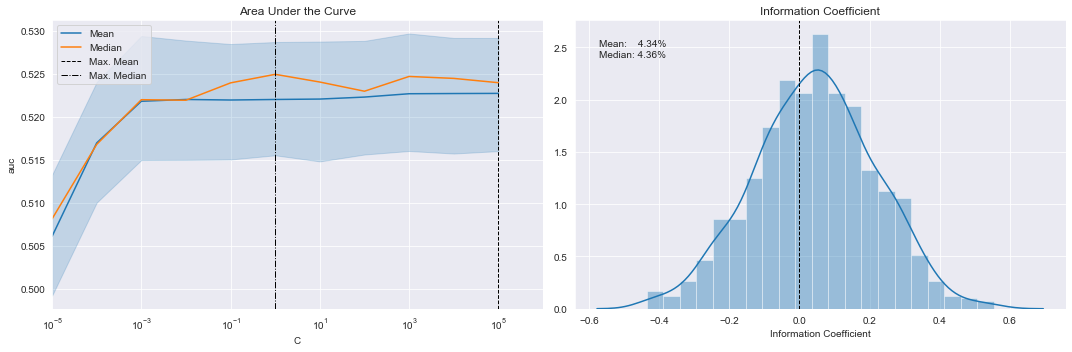

In [33]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_results, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_results.groupby('C').auc.agg(['mean', 'median'])
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(by_alpha['mean'].idxmax(), ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_results[log_results.C==1e5], ax=axes[1])
axes[1].set_title('Information Coefficient')
fig.tight_layout()
fig.savefig('figures/log_results', dpi=300);